# RandomizedSearchCV

# apply best search configuration

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71717 entries, 0 to 71716
Columns: 161 entries, Timestamp to Z_Intensity
dtypes: bool(1), float64(117), int64(23), object(20)
memory usage: 87.6+ MB


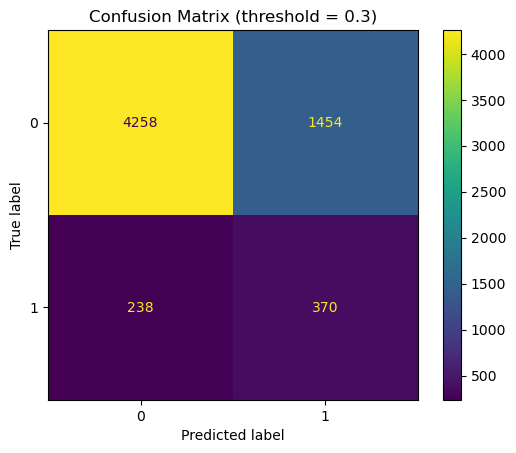

📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9471    0.7454    0.8342      5712
           1     0.2029    0.6086    0.3043       608

    accuracy                         0.7323      6320
   macro avg     0.5750    0.6770    0.5693      6320
weighted avg     0.8755    0.7323    0.7833      6320

📈 Evaluation Metrics:
Accuracy:  0.7323
Precision: 0.2029
Recall:    0.6086
F1 Score:  0.3043
ROC AUC:   0.7437
PR AUC:    0.2170

🔍 Feature Importance (Top 15):
              Feature  Importance
57          Intensity    0.249474
15  mean_intensity_1h    0.159363
13    hungry_weighted    0.074448
44     1_1.5h_pre_std    0.049610
53       Z_Previous_4    0.039892
12           Time_24h    0.036149
2        15m_G_Diff_7    0.026183
0        15m_G_Diff_5    0.025466
50     2_2.5h_pre_std    0.022846
27          TimeInBed    0.018886
29         Sleep_Diff    0.018036
54               Z_HR    0.016585
4        15m_G_Diff_9    0.014779
47     1.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")
df.info()

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity"
    
]

# Remove rows with missing values
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
df_model = df_model[~df_model["StudyID"].isin([8, 40, 59, 86])]

X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)

# Split train/test
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE with dynamic k_neighbors
minority_class_size = np.bincount(y_train_raw)[1]
k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Train model with best hyperparameters
model = RandomForestClassifier(
    n_estimators=1000,
    min_samples_split=50,
    min_samples_leaf=50,
    max_features=None,
    max_depth=50,
    criterion='entropy',
    class_weight=None,
    bootstrap=True,
    random_state=42,
    n_jobs=-1  # 병렬 처리
)
model.fit(X_train, y_train)

# Predict
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluation
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh)
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_thresh, digits=4))
print("📈 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_thresh):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR AUC:    {average_precision_score(y_test, y_proba):.4f}")

# Feature importance
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n🔍 Feature Importance (Top 15):")
print(importances.head(15))


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


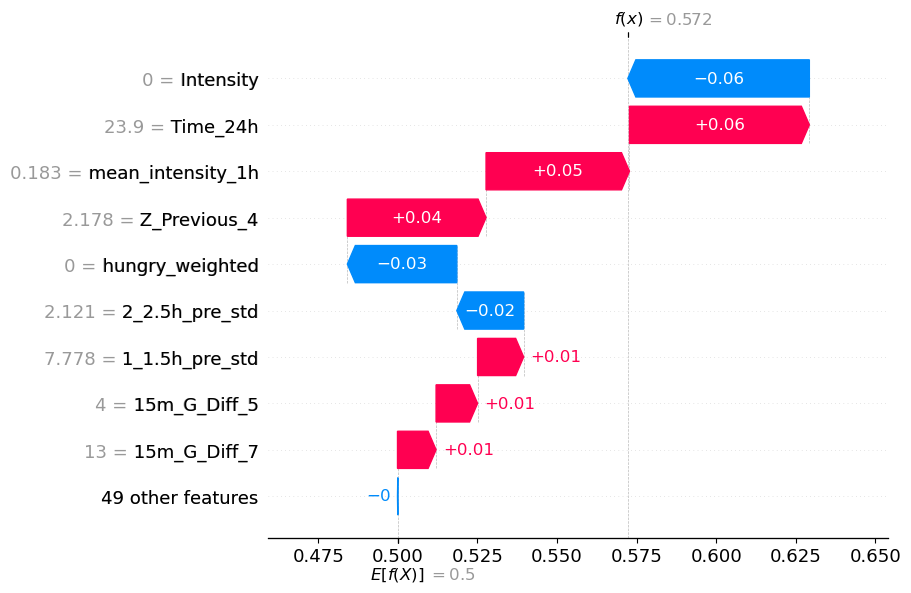

In [7]:
import shap

# SHAP explainer: RandomForestClassifier에 직접 적용
explainer = shap.TreeExplainer(model)

# 확률 0.5 넘는 인덱스 추출
high_prob_indices = np.where(y_proba > 0.5)[0]

if len(high_prob_indices) == 0:
    print("❌ No samples found with predicted probability > 0.5.")
else:
    idx = high_prob_indices[4]  # index 변경 가능
    x_row = X_test.iloc[[idx]]

    # SHAP 값 계산
    shap_values = explainer.shap_values(x_row)

    # Waterfall plot (class 1 기준으로)
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][0],  # class 1의 shap 값
            base_values=explainer.expected_value[1],
            data=x_row.values[0],
            feature_names=x_row.columns.tolist()
        )
    )


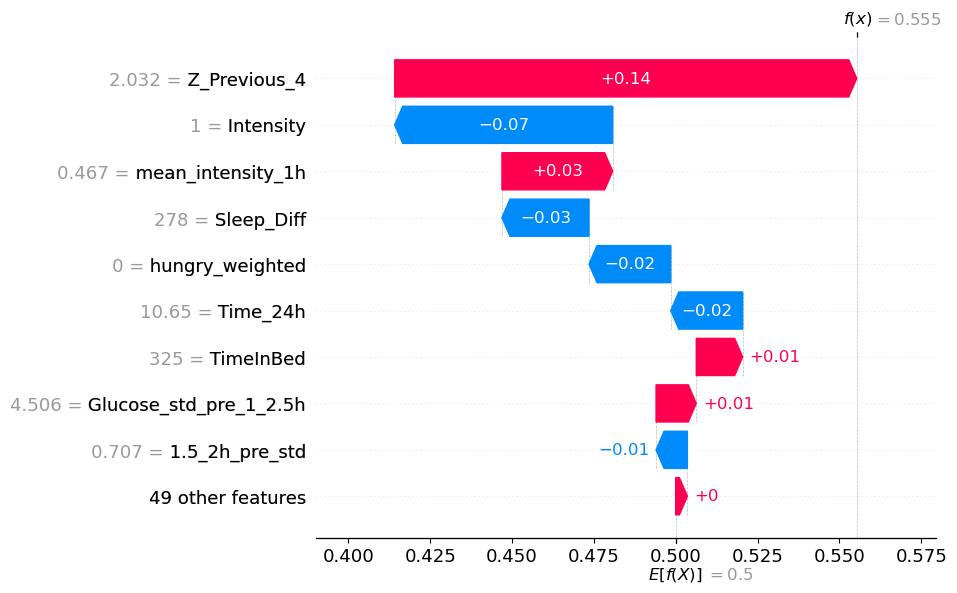

In [30]:
import shap

# SHAP explainer: RandomForestClassifier에 직접 적용
explainer = shap.TreeExplainer(model)

# 확률 0.5 넘는 인덱스 추출
high_prob_indices = np.where(y_proba > 0.5)[0]

if len(high_prob_indices) == 0:
    print("❌ No samples found with predicted probability > 0.5.")
else:
    idx = high_prob_indices[6]  # index 변경 가능
    x_row = X_test.iloc[[idx]]

    # SHAP 값 계산
    shap_values = explainer.shap_values(x_row)

    # Waterfall plot (class 1 기준으로)
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][0],  # class 1의 shap 값
            base_values=explainer.expected_value[1],
            data=x_row.values[0],
            feature_names=x_row.columns.tolist()
        )
    )

In [238]:
intensity_counts = df['Intensity'].value_counts(dropna=False).sort_index()
intensity_counts

Intensity
0.0    57347
1.0    12450
2.0      745
3.0      768
NaN      407
Name: count, dtype: int64

In [240]:
ge_event_rate = df.groupby('Intensity')['GE_1h'].mean()
print(ge_event_rate)


Intensity
0.0    0.083836
1.0    0.126066
2.0    0.166667
3.0    0.154589
Name: GE_1h, dtype: object



📊 GE event 비율 (시간대별)
Time_hour_bin
0     0.059207
1     0.028851
2     0.026688
3     0.027778
4     0.018559
5     0.017525
6     0.032009
7     0.059544
8     0.077138
9     0.080157
10    0.092697
11    0.085214
12    0.156409
13    0.156682
14    0.138498
15    0.131737
16     0.11779
17     0.14075
18    0.157632
19    0.154232
20    0.163831
21     0.13952
22    0.126502
23    0.088608
Name: GE_1h, dtype: object


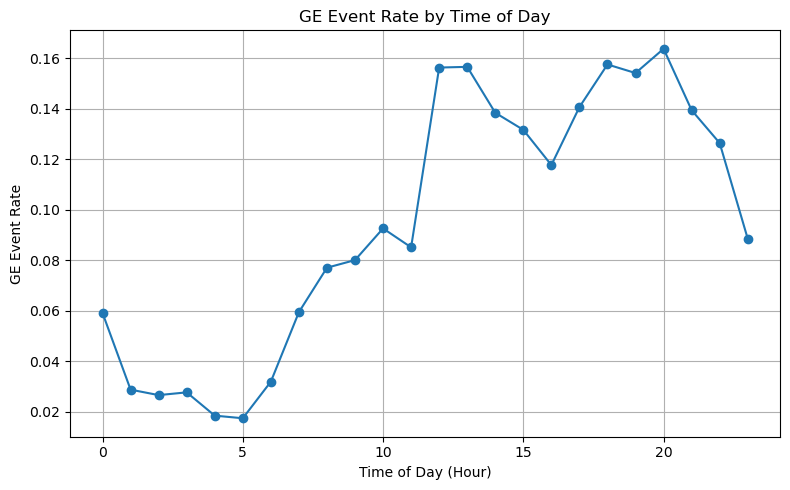

In [80]:
import pandas as pd

# Time_24h가 float 형태로 0~24 사이 값이라고 가정
# 1시간 단위로 bin 생성
df['Time_hour_bin'] = df['Time_24h'].apply(lambda x: int(x))

# 각 시간대 bin별 GE event 비율 계산
ge_rate_by_hour = df.groupby('Time_hour_bin')['GE_1h'].mean()

# 출력
print("\n📊 GE event 비율 (시간대별)")
print(ge_rate_by_hour)

# 시각화 (선택)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(ge_rate_by_hour.index, ge_rate_by_hour.values, marker='o')
plt.xlabel('Time of Day (Hour)')
plt.ylabel('GE Event Rate')
plt.title('GE Event Rate by Time of Day')
plt.grid(True)
plt.tight_layout()
plt.show()


# Validation

# add condition total rate

In [481]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 (rolling=3 적용) -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=3, min_periods=3).sum()
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(2, len(df)):  # 3개 rolling이므로 index 2부터 시작
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour

        if (
            rolling_sum >= 3 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22
        ):
            alert_time = current_time
            success = any(alert_time <= ge_time <= alert_time + timedelta(minutes=120) for ge_time in ge_times)
            alerts.append({"Alert_Time": alert_time, "Success": success})
            last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.2, 0.51, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df, threshold=threshold, cooldown_minutes=120
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)

cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}")

results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

# 구분선 삽입
results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

results_with_sep = pd.DataFrame(results_with_sep)

# 출력
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

print("📊 Early Warning Evaluation (visual logic: 3 consecutive, 2hr cooldown, 08–22h, 2hr GE detection):")
print(results_with_sep.to_string(index=False))


📊 Early Warning Evaluation (visual logic: 3 consecutive, 2hr cooldown, 08–22h, 2hr GE detection):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.20       8           41       17           9       0.529412              32 0.780488     0.219512
     0.20      40           46       29          20       0.689655              26 0.565217     0.434783
     0.20      59           36        9           8       0.888889              28 0.777778     0.222222
     0.20      86           45       25          15       0.600000              30 0.666667     0.333333
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.25       8           33       17           8       0.470588              25 0.757576     0.242424
     0.25      40           32       29          17       0.586207              15 0.468750     0.531250
     0.25      59           26        9           7       0.77

# 30min 2times + Z_Previous 4 >0.1 + pre 4< 130mg/dl

In [110]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Z_Previous_4", "Previous_4_Glucose"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=180):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_glucose = df.loc[i, "Z_Previous_4"]
        pre4_glucose = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_glucose >= 0.1 and
            pre4_glucose < 130
        ):
            alert_time = current_time
            success = any(
                alert_time + timedelta(minutes=60) <= ge_time <= alert_time + timedelta(minutes=180)
                for ge_time in ge_times
            )
            alerts.append({"Alert_Time": alert_time, "Success": success})
            last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.25, 0.41, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df, threshold=threshold, cooldown_minutes=180
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)

cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}")

results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

# 구분선 삽입
results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

results_with_sep = pd.DataFrame(results_with_sep)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

print("📊 Early Warning Evaluation (2 consecutive + Z_Previous_4 ≥ 0.1 + Pre4_Glucose < 130 + cooldown 180min + time window 1–3hr):")
print(results_with_sep.to_string(index=False))


📊 Early Warning Evaluation (2 consecutive + Z_Previous_4 ≥ 0.1 + Pre4_Glucose < 130 + cooldown 180min + time window 1–3hr):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.25       8           23       17           8       0.470588              15 0.652174     0.347826
     0.25      40           23       29          11       0.379310              12 0.521739     0.478261
     0.25      59           18        9           5       0.555556              13 0.722222     0.277778
     0.25      86           22       25          10       0.400000              12 0.545455     0.454545
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.30       8           17       17           6       0.352941              11 0.647059     0.352941
     0.30      40           18       29           6       0.206897              12 0.666667     0.333333
     0.30      59           15      

# 180 -> 210min

In [264]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Z_Previous_4", "Previous_4_Glucose"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=210):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    all_ge_df = df[df["Onset_GE"] == 1].copy()
    all_ge_df["Shifted_Timestamp"] = all_ge_df["Timestamp"] + timedelta(minutes=60)

    ge_times = all_ge_df["Shifted_Timestamp"]

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_glucose = df.loc[i, "Z_Previous_4"]
        pre4_glucose = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_glucose >= 0.1 and
            pre4_glucose < 130
        ):
            last_data_time = df["Timestamp"].max()
            first_data_time = df["Timestamp"].min()

            success = any(
                (current_time + timedelta(minutes=60) <= ge_time <= current_time + timedelta(minutes=210))
                for ge_time in ge_times
            )

            if not success:
                if (last_data_time < current_time + timedelta(minutes=110)) or \
                   (first_data_time > current_time - timedelta(minutes=110)):
                    continue

            alerts.append({"Alert_Time": current_time, "Success": success})
            last_alert_time = current_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.25, 0.41, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df, threshold=threshold, cooldown_minutes=210
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

results_df = pd.DataFrame(results)

cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{float(x):.6f}" if x != "nan" else "nan")

results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

results_with_sep = pd.DataFrame(results_with_sep)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

print("📊 Early Warning Evaluation (2 consecutive + Z_Previous_4 ≥ 0.1 + Pre4_Glucose < 130 + cooldown 210min + time window 1–3.5hr):")
print(results_with_sep.to_string(index=False))


📊 Early Warning Evaluation (2 consecutive + Z_Previous_4 ≥ 0.1 + Pre4_Glucose < 130 + cooldown 210min + time window 1–3.5hr):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.25       8           19       17           6       0.352941              13 0.684211     0.315789
     0.25      40           23       29          11       0.379310              12 0.521739     0.478261
     0.25      59           16        9           6       0.666667              10 0.625000     0.375000
     0.25      86           22       25           9       0.360000              13 0.590909     0.409091
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.30       8           16       17           5       0.294118              11 0.687500     0.312500
     0.30      40           18       29           6       0.206897              12 0.666667     0.333333
     0.30      59           11    

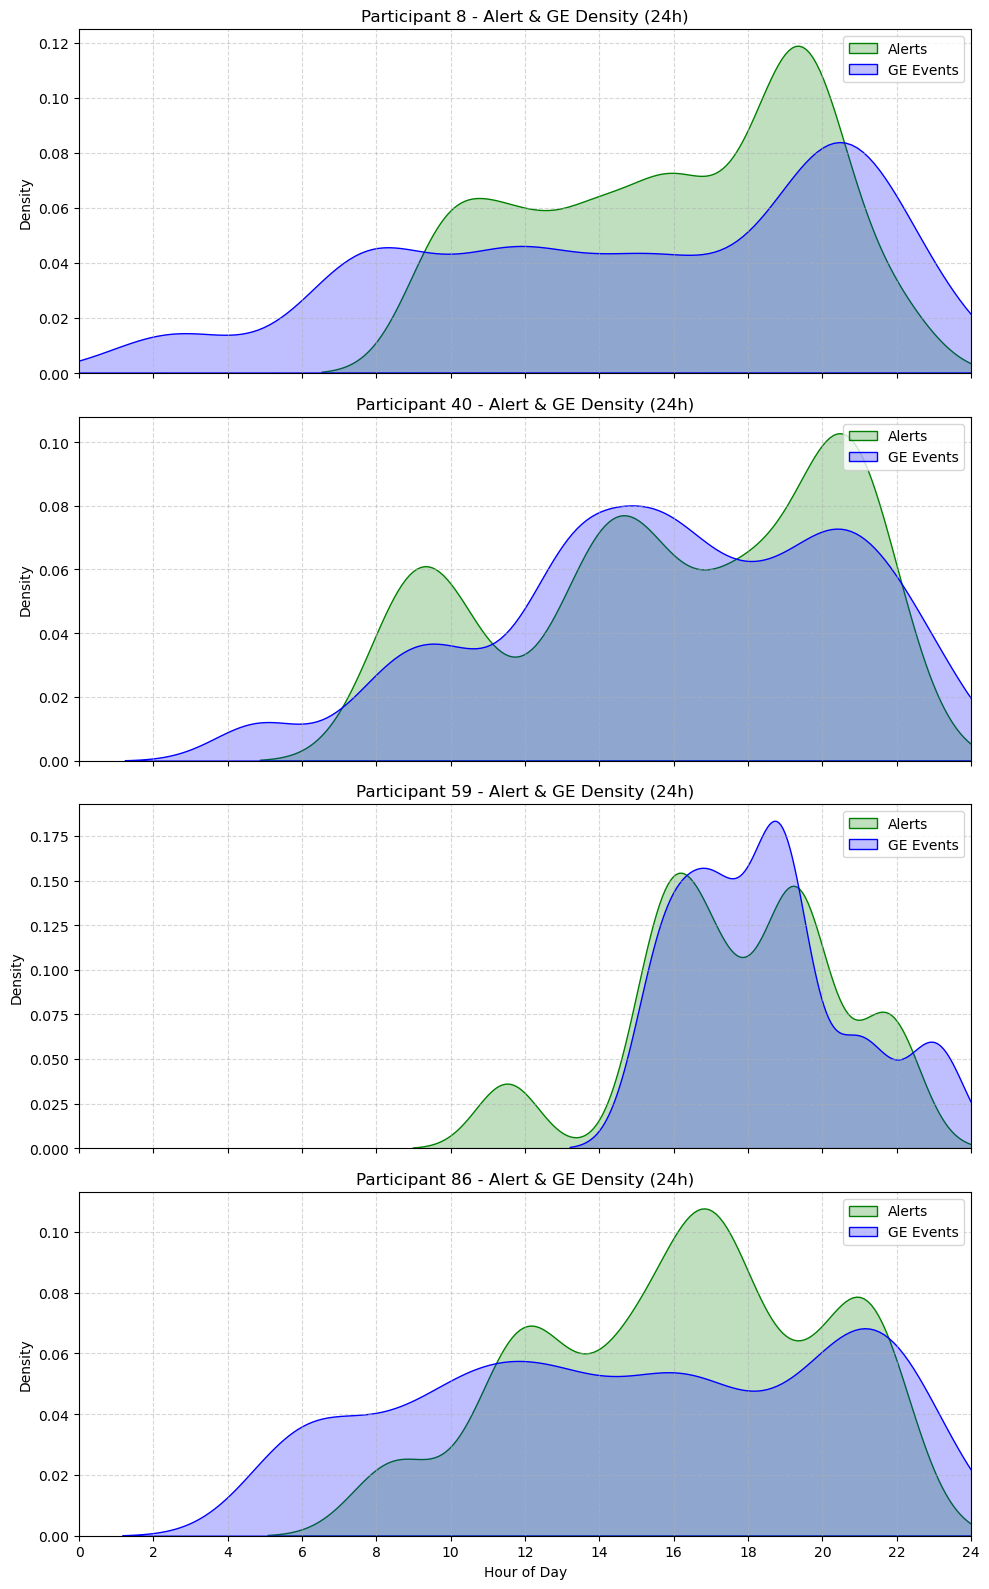

In [360]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# ------------------- 알림 시간 계산 함수 -------------------
def get_alert_times(df, threshold=0.3, cooldown_minutes=210):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_pre4 = df.loc[i, "Z_Previous_4"]
        pre4 = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_pre4 >= 0.1 and
            pre4 < 130
        ):
            alert_times.append(current_time)
            last_alert_time = current_time

    return alert_times

# ------------------- 시각화 함수 -------------------
def plot_alert_vs_ge_density(df, holdout_ids, threshold=0.3, cooldown_minutes=210):
    n = len(holdout_ids)
    fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), sharex=True)

    if n == 1:
        axes = [axes]

    for idx, sid in enumerate(holdout_ids):
        sub_df = df[df["StudyID"] == sid].copy().sort_values("Timestamp").reset_index(drop=True)

        alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
        alert_hours = [t.hour + t.minute/60 for t in alert_times]

        ge_df = sub_df[sub_df["Onset_GE"] == 1]
        ge_hours = [t.hour + t.minute/60 for t in ge_df["Timestamp"]]

        ax = axes[idx]
        sns.kdeplot(alert_hours, fill=True, color="green", label="Alerts", ax=ax, bw_adjust=0.5)
        sns.kdeplot(ge_hours, fill=True, color="blue", label="GE Events", ax=ax, bw_adjust=0.5)

        ax.set_title(f"Participant {sid} - Alert & GE Density (24h)")
        ax.set_ylabel("Density")
        ax.set_xlim(0, 24)
        ax.set_xticks(range(0, 25, 2))
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend()

    axes[-1].set_xlabel("Hour of Day")
    plt.tight_layout()
    plt.show()

# ------------------- 실행 -------------------
holdout_ids = [8, 40, 59, 86]
plot_alert_vs_ge_density(holdout_df, holdout_ids, threshold=0.3, cooldown_minutes=210)


# Visualization, 59, onset ge

# New Condition
## 1-3.5h, 30min 2 times + Z_pre 4 >0.1 + pre4 <130mg/dl, 3.5h cool down


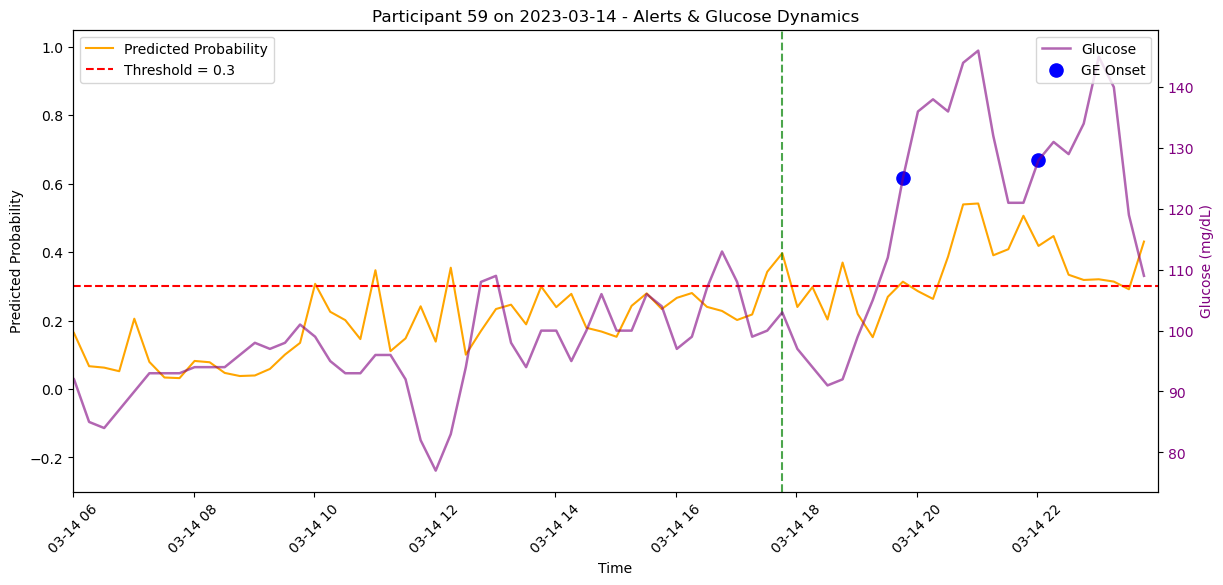

📋 Alert Summary with Delta and Slope:
         Alert_Time  Success    FP     Closest_GE_Time  Time_Diff_Minutes  Glucose_Delta_1_3.5hr  Glucose_Slope_0_3.5hr
2023-03-14 17:46:00     True False 2023-03-14 19:46:00              120.0                     43                  0.276

✅ Total Alerts: 1 | 🏆 Success: 1 | ❌ FP: 0


In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.linear_model import LinearRegression

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Z_Previous_4", "Previous_4_Glucose"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 알림 탐지 함수 -------------------
def get_alert_times(df, threshold=0.3, cooldown_minutes=210):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    all_ge_df = df[df["Onset_GE"] == 1].copy()
    all_ge_df["Shifted_Timestamp"] = all_ge_df["Timestamp"] + timedelta(minutes=60)
    ge_times = all_ge_df["Shifted_Timestamp"]

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_pre4 = df.loc[i, "Z_Previous_4"]
        pre4 = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_pre4 >= 0.1 and
            pre4 < 130
        ):
            last_data_time = df["Timestamp"].max()
            first_data_time = df["Timestamp"].min()

            success = any((current_time + timedelta(minutes=60) <= ge <= current_time + timedelta(minutes=210)) for ge in ge_times)

            if not success:
                if (last_data_time < current_time + timedelta(minutes=110)) or (first_data_time > current_time - timedelta(minutes=110)):
                    continue

            alert_times.append(current_time)
            last_alert_time = current_time

    return alert_times

# ------------------- 기울기 계산 함수 -------------------
def calculate_slope(timestamps, glucose_values):
    timestamps = timestamps.reset_index(drop=True)
    glucose_values = glucose_values.reset_index(drop=True)

    if len(timestamps) < 2:
        return np.nan

    time_minutes = np.array([(t - timestamps.iloc[0]).total_seconds() / 60 for t in timestamps]).reshape(-1, 1)
    glucose_values = glucose_values.to_numpy().reshape(-1, 1)
    model = LinearRegression().fit(time_minutes, glucose_values)
    return round(model.coef_[0][0], 3)

# ------------------- 시각화 함수 -------------------
def plot_alerts_with_detailed_summary(df, study_id, date, threshold=0.3, cooldown_minutes=210):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)
    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    onset_df = sub_df[sub_df["Onset_GE"] == 1].copy()
    onset_df["Shifted_Timestamp"] = onset_df["Timestamp"] + timedelta(minutes=60)
    shifted_onset_times = onset_df["Shifted_Timestamp"].tolist()

    results = []
    success_count, fp_count = 0, 0

    for alert_time in alert_times:
        future_ge_times = [t for t in shifted_onset_times if t >= alert_time]
        closest_ge, time_diff = (pd.NaT, np.nan)
        if future_ge_times:
            closest_ge = min(future_ge_times)
            time_diff = round((closest_ge - alert_time).total_seconds() / 60, 1)

        success = any(alert_time + timedelta(minutes=60) <= t <= alert_time + timedelta(minutes=210) for t in future_ge_times)

        glucose_0 = sub_df.loc[sub_df["Timestamp"] <= alert_time, "Glucose"].iloc[-1]
        window_1_3hr = sub_df[(sub_df["Timestamp"] >= alert_time + timedelta(minutes=60)) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        delta = (window_1_3hr["Glucose"].max() - glucose_0) if not window_1_3hr.empty else np.nan

        window_0_3hr = sub_df[(sub_df["Timestamp"] >= alert_time) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        slope = calculate_slope(window_0_3hr["Timestamp"], window_0_3hr["Glucose"]) if not window_0_3hr.empty else np.nan

        results.append({
            "Alert_Time": alert_time,
            "Success": success,
            "FP": not success,
            "Closest_GE_Time": closest_ge,
            "Time_Diff_Minutes": time_diff,
            "Glucose_Delta_1_3.5hr": round(delta, 1) if pd.notna(delta) else np.nan,
            "Glucose_Slope_0_3.5hr": slope
        })

        success_count += success
        fp_count += not success

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)
    ax1.set_ylabel("Predicted Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    plt.xticks(rotation=45)

    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")
        if not onset_df.empty:
            shifted_times = onset_df["Shifted_Timestamp"]
            glucose_interp = np.interp(
                shifted_times.astype(np.int64),
                sub_df["Timestamp"].astype(np.int64),
                sub_df["Glucose"]
            )
            ax2.scatter(shifted_times, glucose_interp, color="blue", s=90, label="GE Onset")
        ax2.legend(loc="upper right")

    plt.title(f"Participant {study_id} on {date} - Alerts & Glucose Dynamics")
    plt.show()

    result_df = pd.DataFrame(results)
    print("📋 Alert Summary with Delta and Slope:")
    print(result_df.to_string(index=False))
    print(f"\n✅ Total Alerts: {len(alert_times)} | 🏆 Success: {success_count} | ❌ FP: {fp_count}")

# ------------------- 실행 예시 -------------------
participant_id = 59
specific_date = pd.to_datetime("2023-03-14").date()
plot_alerts_with_detailed_summary(holdout_df, participant_id, specific_date, threshold=0.3, cooldown_minutes=210)


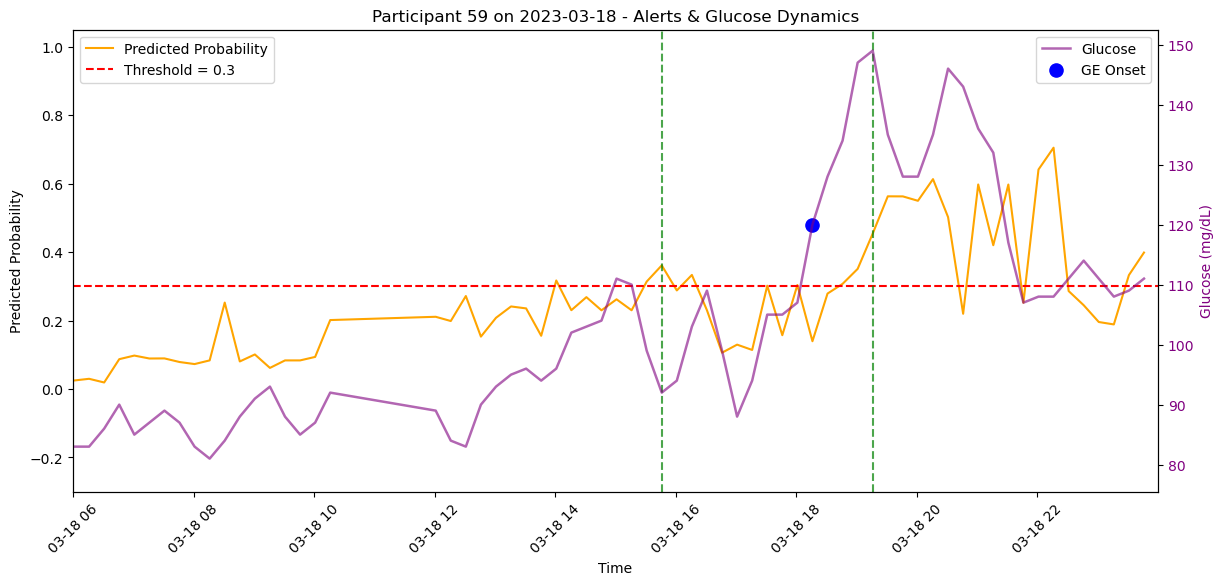

📋 Alert Summary with Delta and Slope:
         Alert_Time  Success    FP     Closest_GE_Time  Time_Diff_Minutes  Glucose_Delta_1_3.5hr  Glucose_Slope_0_3.5hr
2023-03-18 15:46:00     True False 2023-03-18 18:16:00              150.0                     57                  0.252
2023-03-18 19:16:00    False  True                 NaT                NaN                     -3                 -0.172

✅ Total Alerts: 2 | 🏆 Success: 1 | ❌ FP: 1


In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.linear_model import LinearRegression

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Z_Previous_4", "Previous_4_Glucose"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 알림 탐지 함수 -------------------
def get_alert_times(df, threshold=0.3, cooldown_minutes=210):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    all_ge_df = df[df["Onset_GE"] == 1].copy()
    all_ge_df["Shifted_Timestamp"] = all_ge_df["Timestamp"] + timedelta(minutes=60)
    ge_times = all_ge_df["Shifted_Timestamp"]

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_pre4 = df.loc[i, "Z_Previous_4"]
        pre4 = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_pre4 >= 0.1 and
            pre4 < 130
        ):
            last_data_time = df["Timestamp"].max()
            first_data_time = df["Timestamp"].min()

            success = any((current_time + timedelta(minutes=60) <= ge <= current_time + timedelta(minutes=210)) for ge in ge_times)

            if not success:
                if (last_data_time < current_time + timedelta(minutes=110)) or (first_data_time > current_time - timedelta(minutes=110)):
                    continue

            alert_times.append(current_time)
            last_alert_time = current_time

    return alert_times

# ------------------- 기울기 계산 함수 -------------------
def calculate_slope(timestamps, glucose_values):
    timestamps = timestamps.reset_index(drop=True)
    glucose_values = glucose_values.reset_index(drop=True)

    if len(timestamps) < 2:
        return np.nan

    time_minutes = np.array([(t - timestamps.iloc[0]).total_seconds() / 60 for t in timestamps]).reshape(-1, 1)
    glucose_values = glucose_values.to_numpy().reshape(-1, 1)
    model = LinearRegression().fit(time_minutes, glucose_values)
    return round(model.coef_[0][0], 3)

# ------------------- 시각화 함수 -------------------
def plot_alerts_with_detailed_summary(df, study_id, date, threshold=0.3, cooldown_minutes=210):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)
    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    onset_df = sub_df[sub_df["Onset_GE"] == 1].copy()
    onset_df["Shifted_Timestamp"] = onset_df["Timestamp"] + timedelta(minutes=60)
    shifted_onset_times = onset_df["Shifted_Timestamp"].tolist()

    results = []
    success_count, fp_count = 0, 0

    for alert_time in alert_times:
        future_ge_times = [t for t in shifted_onset_times if t >= alert_time]
        closest_ge, time_diff = (pd.NaT, np.nan)
        if future_ge_times:
            closest_ge = min(future_ge_times)
            time_diff = round((closest_ge - alert_time).total_seconds() / 60, 1)

        success = any(alert_time + timedelta(minutes=60) <= t <= alert_time + timedelta(minutes=210) for t in future_ge_times)

        glucose_0 = sub_df.loc[sub_df["Timestamp"] <= alert_time, "Glucose"].iloc[-1]
        window_1_3hr = sub_df[(sub_df["Timestamp"] >= alert_time + timedelta(minutes=60)) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        delta = (window_1_3hr["Glucose"].max() - glucose_0) if not window_1_3hr.empty else np.nan

        window_0_3hr = sub_df[(sub_df["Timestamp"] >= alert_time) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        slope = calculate_slope(window_0_3hr["Timestamp"], window_0_3hr["Glucose"]) if not window_0_3hr.empty else np.nan

        results.append({
            "Alert_Time": alert_time,
            "Success": success,
            "FP": not success,
            "Closest_GE_Time": closest_ge,
            "Time_Diff_Minutes": time_diff,
            "Glucose_Delta_1_3.5hr": round(delta, 1) if pd.notna(delta) else np.nan,
            "Glucose_Slope_0_3.5hr": slope
        })

        success_count += success
        fp_count += not success

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)
    ax1.set_ylabel("Predicted Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    plt.xticks(rotation=45)

    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")
        if not onset_df.empty:
            shifted_times = onset_df["Shifted_Timestamp"]
            glucose_interp = np.interp(
                shifted_times.astype(np.int64),
                sub_df["Timestamp"].astype(np.int64),
                sub_df["Glucose"]
            )
            ax2.scatter(shifted_times, glucose_interp, color="blue", s=90, label="GE Onset")
        ax2.legend(loc="upper right")

    plt.title(f"Participant {study_id} on {date} - Alerts & Glucose Dynamics")
    plt.show()

    result_df = pd.DataFrame(results)
    print("📋 Alert Summary with Delta and Slope:")
    print(result_df.to_string(index=False))
    print(f"\n✅ Total Alerts: {len(alert_times)} | 🏆 Success: {success_count} | ❌ FP: {fp_count}")

# ------------------- 실행 예시 -------------------
participant_id = 59
specific_date = pd.to_datetime("2023-03-18").date()
plot_alerts_with_detailed_summary(holdout_df, participant_id, specific_date, threshold=0.3, cooldown_minutes=210)


# 40

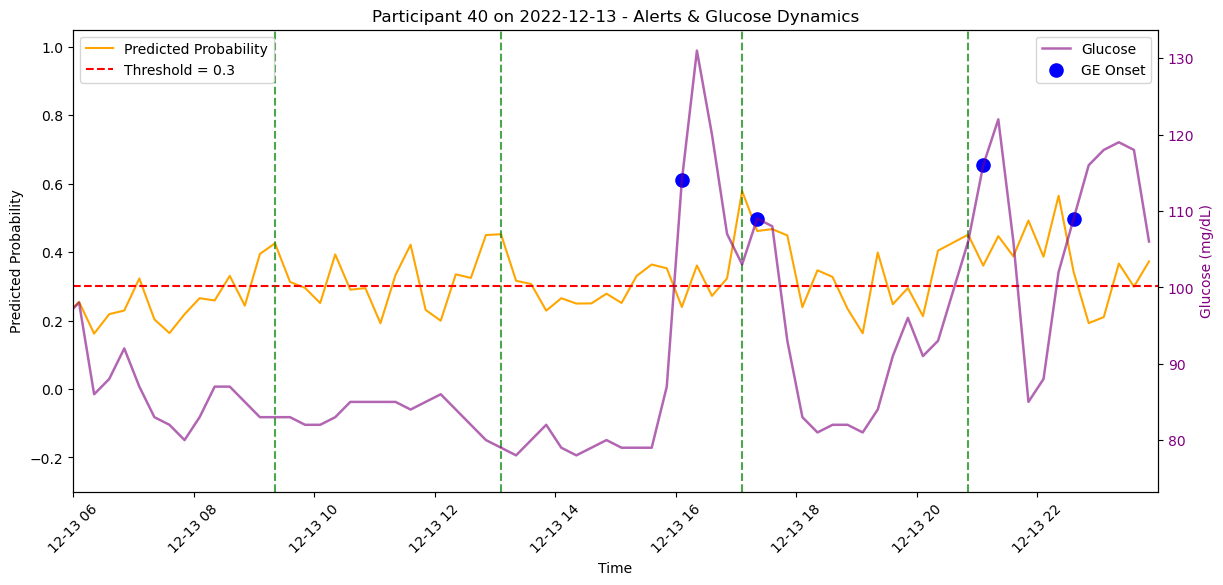

📋 Alert Summary with Delta and Slope:
         Alert_Time  Success    FP     Closest_GE_Time  Time_Diff_Minutes  Glucose_Delta_1_3.5hr  Glucose_Slope_0_3.5hr
2022-12-13 09:21:00    False  True 2022-12-13 16:06:00              405.0                      3                  0.001
2022-12-13 13:06:00     True False 2022-12-13 16:06:00              180.0                     52                  0.190
2022-12-13 17:06:00    False  True 2022-12-13 17:21:00               15.0                     -7                 -0.065
2022-12-13 20:51:00     True False 2022-12-13 21:06:00               15.0                     13                  0.043

✅ Total Alerts: 4 | 🏆 Success: 2 | ❌ FP: 2


In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.linear_model import LinearRegression

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Z_Previous_4", "Previous_4_Glucose"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 알림 탐지 함수 -------------------
def get_alert_times(df, threshold=0.3, cooldown_minutes=210):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    all_ge_df = df[df["Onset_GE"] == 1].copy()
    all_ge_df["Shifted_Timestamp"] = all_ge_df["Timestamp"] + timedelta(minutes=60)
    ge_times = all_ge_df["Shifted_Timestamp"]

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_pre4 = df.loc[i, "Z_Previous_4"]
        pre4 = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_pre4 >= 0.1 and
            pre4 < 130
        ):
            last_data_time = df["Timestamp"].max()
            first_data_time = df["Timestamp"].min()

            success = any((current_time + timedelta(minutes=60) <= ge <= current_time + timedelta(minutes=210)) for ge in ge_times)

            if not success:
                if (last_data_time < current_time + timedelta(minutes=110)) or (first_data_time > current_time - timedelta(minutes=110)):
                    continue

            alert_times.append(current_time)
            last_alert_time = current_time

    return alert_times

# ------------------- 기울기 계산 함수 -------------------
def calculate_slope(timestamps, glucose_values):
    timestamps = timestamps.reset_index(drop=True)
    glucose_values = glucose_values.reset_index(drop=True)

    if len(timestamps) < 2:
        return np.nan

    time_minutes = np.array([(t - timestamps.iloc[0]).total_seconds() / 60 for t in timestamps]).reshape(-1, 1)
    glucose_values = glucose_values.to_numpy().reshape(-1, 1)
    model = LinearRegression().fit(time_minutes, glucose_values)
    return round(model.coef_[0][0], 3)

# ------------------- 시각화 함수 -------------------
def plot_alerts_with_detailed_summary(df, study_id, date, threshold=0.3, cooldown_minutes=210):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)
    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    onset_df = sub_df[sub_df["Onset_GE"] == 1].copy()
    onset_df["Shifted_Timestamp"] = onset_df["Timestamp"] + timedelta(minutes=60)
    shifted_onset_times = onset_df["Shifted_Timestamp"].tolist()

    results = []
    success_count, fp_count = 0, 0

    for alert_time in alert_times:
        future_ge_times = [t for t in shifted_onset_times if t >= alert_time]
        closest_ge, time_diff = (pd.NaT, np.nan)
        if future_ge_times:
            closest_ge = min(future_ge_times)
            time_diff = round((closest_ge - alert_time).total_seconds() / 60, 1)

        success = any(alert_time + timedelta(minutes=60) <= t <= alert_time + timedelta(minutes=210) for t in future_ge_times)

        glucose_0 = sub_df.loc[sub_df["Timestamp"] <= alert_time, "Glucose"].iloc[-1]
        window_1_3hr = sub_df[(sub_df["Timestamp"] >= alert_time + timedelta(minutes=60)) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        delta = (window_1_3hr["Glucose"].max() - glucose_0) if not window_1_3hr.empty else np.nan

        window_0_3hr = sub_df[(sub_df["Timestamp"] >= alert_time) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        slope = calculate_slope(window_0_3hr["Timestamp"], window_0_3hr["Glucose"]) if not window_0_3hr.empty else np.nan

        results.append({
            "Alert_Time": alert_time,
            "Success": success,
            "FP": not success,
            "Closest_GE_Time": closest_ge,
            "Time_Diff_Minutes": time_diff,
            "Glucose_Delta_1_3.5hr": round(delta, 1) if pd.notna(delta) else np.nan,
            "Glucose_Slope_0_3.5hr": slope
        })

        success_count += success
        fp_count += not success

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)
    ax1.set_ylabel("Predicted Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    plt.xticks(rotation=45)

    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")
        if not onset_df.empty:
            shifted_times = onset_df["Shifted_Timestamp"]
            glucose_interp = np.interp(
                shifted_times.astype(np.int64),
                sub_df["Timestamp"].astype(np.int64),
                sub_df["Glucose"]
            )
            ax2.scatter(shifted_times, glucose_interp, color="blue", s=90, label="GE Onset")
        ax2.legend(loc="upper right")

    plt.title(f"Participant {study_id} on {date} - Alerts & Glucose Dynamics")
    plt.show()

    result_df = pd.DataFrame(results)
    print("📋 Alert Summary with Delta and Slope:")
    print(result_df.to_string(index=False))
    print(f"\n✅ Total Alerts: {len(alert_times)} | 🏆 Success: {success_count} | ❌ FP: {fp_count}")

# ------------------- 실행 예시 -------------------
participant_id = 40
specific_date = pd.to_datetime("2022-12-13").date()
plot_alerts_with_detailed_summary(holdout_df, participant_id, specific_date, threshold=0.3, cooldown_minutes=210)


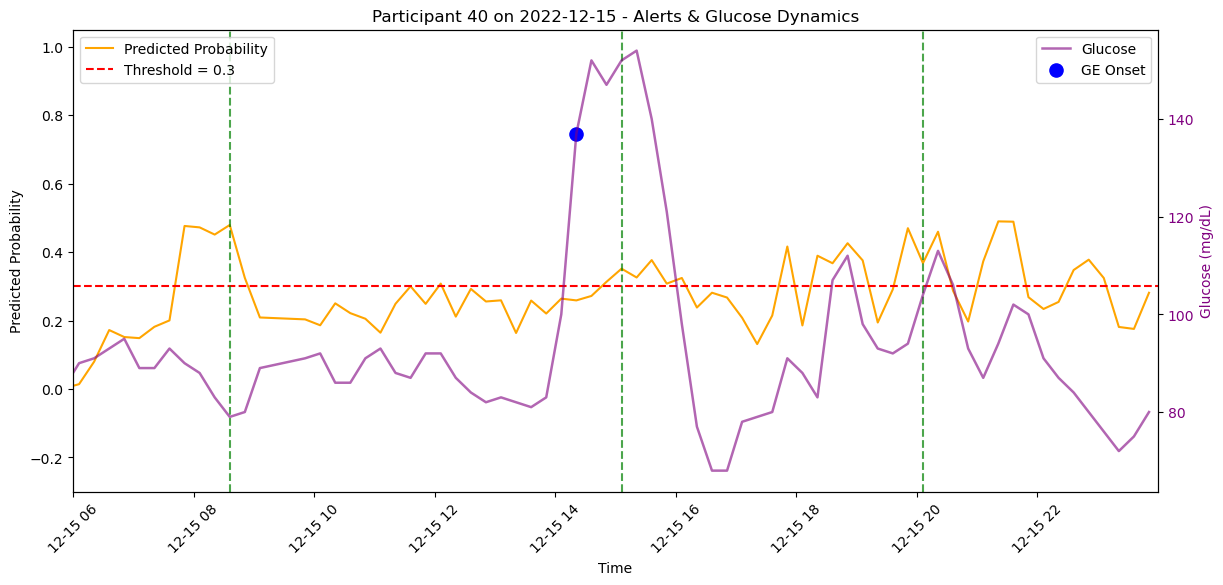

📋 Alert Summary with Delta and Slope:
         Alert_Time  Success   FP     Closest_GE_Time  Time_Diff_Minutes  Glucose_Delta_1_3.5hr  Glucose_Slope_0_3.5hr
2022-12-15 08:36:00    False True 2022-12-15 14:21:00              345.0                     14                  0.043
2022-12-15 15:06:00    False True                 NaT                NaN                    -45                 -0.276
2022-12-15 20:06:00    False True                 NaT                NaN                     -2                 -0.163

✅ Total Alerts: 3 | 🏆 Success: 0 | ❌ FP: 3


In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.linear_model import LinearRegression

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Z_Previous_4", "Previous_4_Glucose"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 알림 탐지 함수 -------------------
def get_alert_times(df, threshold=0.3, cooldown_minutes=210):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    all_ge_df = df[df["Onset_GE"] == 1].copy()
    all_ge_df["Shifted_Timestamp"] = all_ge_df["Timestamp"] + timedelta(minutes=60)
    ge_times = all_ge_df["Shifted_Timestamp"]

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_pre4 = df.loc[i, "Z_Previous_4"]
        pre4 = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_pre4 >= 0.1 and
            pre4 < 130
        ):
            last_data_time = df["Timestamp"].max()
            first_data_time = df["Timestamp"].min()

            success = any((current_time + timedelta(minutes=60) <= ge <= current_time + timedelta(minutes=210)) for ge in ge_times)

            if not success:
                if (last_data_time < current_time + timedelta(minutes=110)) or (first_data_time > current_time - timedelta(minutes=110)):
                    continue

            alert_times.append(current_time)
            last_alert_time = current_time

    return alert_times

# ------------------- 기울기 계산 함수 -------------------
def calculate_slope(timestamps, glucose_values):
    timestamps = timestamps.reset_index(drop=True)
    glucose_values = glucose_values.reset_index(drop=True)

    if len(timestamps) < 2:
        return np.nan

    time_minutes = np.array([(t - timestamps.iloc[0]).total_seconds() / 60 for t in timestamps]).reshape(-1, 1)
    glucose_values = glucose_values.to_numpy().reshape(-1, 1)
    model = LinearRegression().fit(time_minutes, glucose_values)
    return round(model.coef_[0][0], 3)

# ------------------- 시각화 함수 -------------------
def plot_alerts_with_detailed_summary(df, study_id, date, threshold=0.3, cooldown_minutes=210):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)
    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    onset_df = sub_df[sub_df["Onset_GE"] == 1].copy()
    onset_df["Shifted_Timestamp"] = onset_df["Timestamp"] + timedelta(minutes=60)
    shifted_onset_times = onset_df["Shifted_Timestamp"].tolist()

    results = []
    success_count, fp_count = 0, 0

    for alert_time in alert_times:
        future_ge_times = [t for t in shifted_onset_times if t >= alert_time]
        closest_ge, time_diff = (pd.NaT, np.nan)
        if future_ge_times:
            closest_ge = min(future_ge_times)
            time_diff = round((closest_ge - alert_time).total_seconds() / 60, 1)

        success = any(alert_time + timedelta(minutes=60) <= t <= alert_time + timedelta(minutes=210) for t in future_ge_times)

        glucose_0 = sub_df.loc[sub_df["Timestamp"] <= alert_time, "Glucose"].iloc[-1]
        window_1_3hr = sub_df[(sub_df["Timestamp"] >= alert_time + timedelta(minutes=60)) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        delta = (window_1_3hr["Glucose"].max() - glucose_0) if not window_1_3hr.empty else np.nan

        window_0_3hr = sub_df[(sub_df["Timestamp"] >= alert_time) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        slope = calculate_slope(window_0_3hr["Timestamp"], window_0_3hr["Glucose"]) if not window_0_3hr.empty else np.nan

        results.append({
            "Alert_Time": alert_time,
            "Success": success,
            "FP": not success,
            "Closest_GE_Time": closest_ge,
            "Time_Diff_Minutes": time_diff,
            "Glucose_Delta_1_3.5hr": round(delta, 1) if pd.notna(delta) else np.nan,
            "Glucose_Slope_0_3.5hr": slope
        })

        success_count += success
        fp_count += not success

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)
    ax1.set_ylabel("Predicted Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    plt.xticks(rotation=45)

    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")
        if not onset_df.empty:
            shifted_times = onset_df["Shifted_Timestamp"]
            glucose_interp = np.interp(
                shifted_times.astype(np.int64),
                sub_df["Timestamp"].astype(np.int64),
                sub_df["Glucose"]
            )
            ax2.scatter(shifted_times, glucose_interp, color="blue", s=90, label="GE Onset")
        ax2.legend(loc="upper right")

    plt.title(f"Participant {study_id} on {date} - Alerts & Glucose Dynamics")
    plt.show()

    result_df = pd.DataFrame(results)
    print("📋 Alert Summary with Delta and Slope:")
    print(result_df.to_string(index=False))
    print(f"\n✅ Total Alerts: {len(alert_times)} | 🏆 Success: {success_count} | ❌ FP: {fp_count}")

# ------------------- 실행 예시 -------------------
participant_id = 40
specific_date = pd.to_datetime("2022-12-15").date()
plot_alerts_with_detailed_summary(holdout_df, participant_id, specific_date, threshold=0.3, cooldown_minutes=210)


# 8

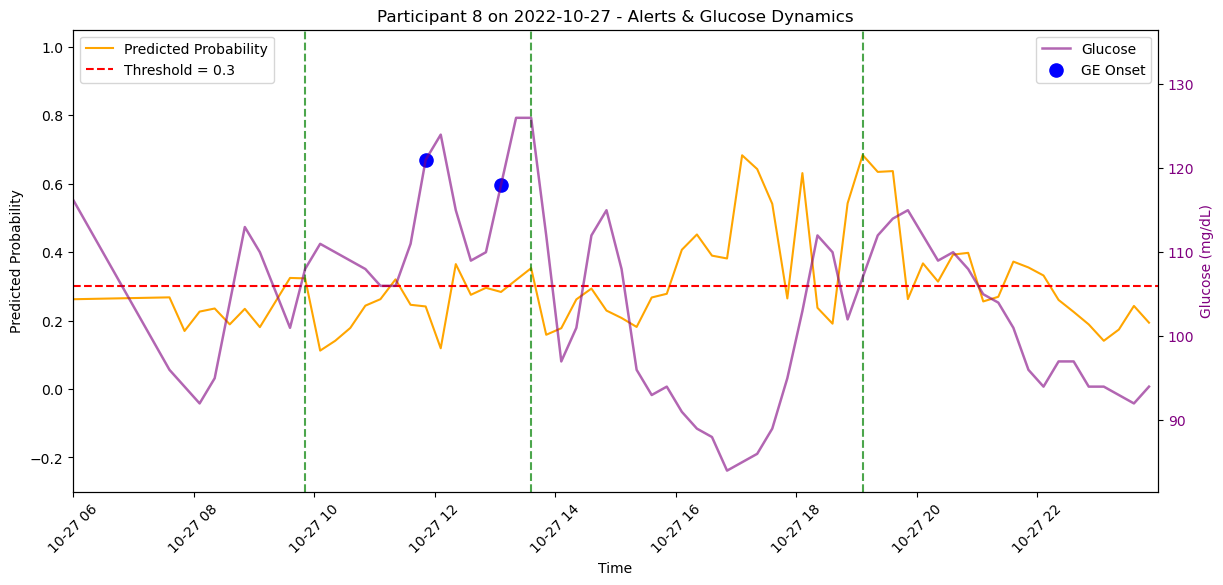

📋 Alert Summary with Delta and Slope:
         Alert_Time  Success    FP     Closest_GE_Time  Time_Diff_Minutes  Glucose_Delta_1_3.5hr  Glucose_Slope_0_3.5hr
2022-10-27 09:51:00     True False 2022-10-27 11:51:00              120.0                     18                  0.057
2022-10-27 13:36:00    False  True                 NaT                NaN                    -11                 -0.159
2022-10-27 19:06:00    False  True                 NaT                NaN                      5                 -0.091

✅ Total Alerts: 3 | 🏆 Success: 1 | ❌ FP: 2


In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.linear_model import LinearRegression

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Z_Previous_4", "Previous_4_Glucose"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 알림 탐지 함수 -------------------
def get_alert_times(df, threshold=0.3, cooldown_minutes=210):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    all_ge_df = df[df["Onset_GE"] == 1].copy()
    all_ge_df["Shifted_Timestamp"] = all_ge_df["Timestamp"] + timedelta(minutes=60)
    ge_times = all_ge_df["Shifted_Timestamp"]

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_pre4 = df.loc[i, "Z_Previous_4"]
        pre4 = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_pre4 >= 0.1 and
            pre4 < 130
        ):
            last_data_time = df["Timestamp"].max()
            first_data_time = df["Timestamp"].min()

            success = any((current_time + timedelta(minutes=60) <= ge <= current_time + timedelta(minutes=210)) for ge in ge_times)

            if not success:
                if (last_data_time < current_time + timedelta(minutes=110)) or (first_data_time > current_time - timedelta(minutes=110)):
                    continue

            alert_times.append(current_time)
            last_alert_time = current_time

    return alert_times

# ------------------- 기울기 계산 함수 -------------------
def calculate_slope(timestamps, glucose_values):
    timestamps = timestamps.reset_index(drop=True)
    glucose_values = glucose_values.reset_index(drop=True)

    if len(timestamps) < 2:
        return np.nan

    time_minutes = np.array([(t - timestamps.iloc[0]).total_seconds() / 60 for t in timestamps]).reshape(-1, 1)
    glucose_values = glucose_values.to_numpy().reshape(-1, 1)
    model = LinearRegression().fit(time_minutes, glucose_values)
    return round(model.coef_[0][0], 3)

# ------------------- 시각화 함수 -------------------
def plot_alerts_with_detailed_summary(df, study_id, date, threshold=0.3, cooldown_minutes=210):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)
    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    onset_df = sub_df[sub_df["Onset_GE"] == 1].copy()
    onset_df["Shifted_Timestamp"] = onset_df["Timestamp"] + timedelta(minutes=60)
    shifted_onset_times = onset_df["Shifted_Timestamp"].tolist()

    results = []
    success_count, fp_count = 0, 0

    for alert_time in alert_times:
        future_ge_times = [t for t in shifted_onset_times if t >= alert_time]
        closest_ge, time_diff = (pd.NaT, np.nan)
        if future_ge_times:
            closest_ge = min(future_ge_times)
            time_diff = round((closest_ge - alert_time).total_seconds() / 60, 1)

        success = any(alert_time + timedelta(minutes=60) <= t <= alert_time + timedelta(minutes=210) for t in future_ge_times)

        glucose_0 = sub_df.loc[sub_df["Timestamp"] <= alert_time, "Glucose"].iloc[-1]
        window_1_3hr = sub_df[(sub_df["Timestamp"] >= alert_time + timedelta(minutes=60)) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        delta = (window_1_3hr["Glucose"].max() - glucose_0) if not window_1_3hr.empty else np.nan

        window_0_3hr = sub_df[(sub_df["Timestamp"] >= alert_time) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        slope = calculate_slope(window_0_3hr["Timestamp"], window_0_3hr["Glucose"]) if not window_0_3hr.empty else np.nan

        results.append({
            "Alert_Time": alert_time,
            "Success": success,
            "FP": not success,
            "Closest_GE_Time": closest_ge,
            "Time_Diff_Minutes": time_diff,
            "Glucose_Delta_1_3.5hr": round(delta, 1) if pd.notna(delta) else np.nan,
            "Glucose_Slope_0_3.5hr": slope
        })

        success_count += success
        fp_count += not success

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)
    ax1.set_ylabel("Predicted Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    plt.xticks(rotation=45)

    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")
        if not onset_df.empty:
            shifted_times = onset_df["Shifted_Timestamp"]
            glucose_interp = np.interp(
                shifted_times.astype(np.int64),
                sub_df["Timestamp"].astype(np.int64),
                sub_df["Glucose"]
            )
            ax2.scatter(shifted_times, glucose_interp, color="blue", s=90, label="GE Onset")
        ax2.legend(loc="upper right")

    plt.title(f"Participant {study_id} on {date} - Alerts & Glucose Dynamics")
    plt.show()

    result_df = pd.DataFrame(results)
    print("📋 Alert Summary with Delta and Slope:")
    print(result_df.to_string(index=False))
    print(f"\n✅ Total Alerts: {len(alert_times)} | 🏆 Success: {success_count} | ❌ FP: {fp_count}")

# ------------------- 실행 예시 -------------------
participant_id = 8
specific_date = pd.to_datetime("2022-10-27").date()
plot_alerts_with_detailed_summary(holdout_df, participant_id, specific_date, threshold=0.3, cooldown_minutes=210)

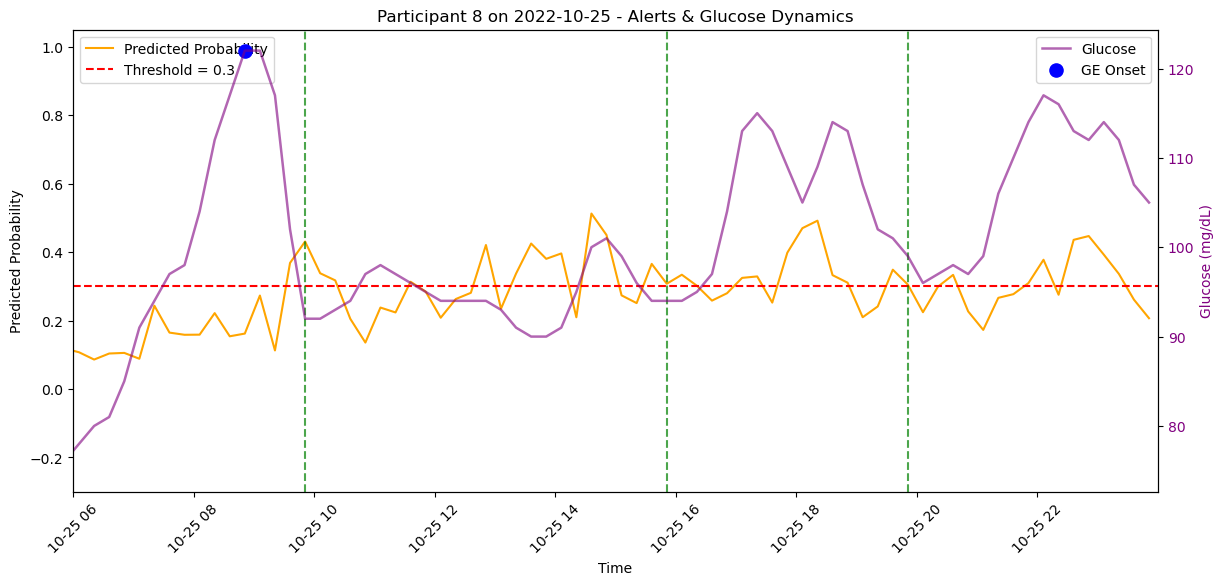

📋 Alert Summary with Delta and Slope:
         Alert_Time  Success   FP Closest_GE_Time  Time_Diff_Minutes  Glucose_Delta_1_3.5hr  Glucose_Slope_0_3.5hr
2022-10-25 09:51:00    False True             NaT                NaN                      6                 -0.004
2022-10-25 15:51:00    False True             NaT                NaN                     21                  0.068
2022-10-25 19:51:00    False True             NaT                NaN                     18                  0.104

✅ Total Alerts: 3 | 🏆 Success: 0 | ❌ FP: 3


In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.linear_model import LinearRegression

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Z_Previous_4", "Previous_4_Glucose"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 알림 탐지 함수 -------------------
def get_alert_times(df, threshold=0.3, cooldown_minutes=210):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    all_ge_df = df[df["Onset_GE"] == 1].copy()
    all_ge_df["Shifted_Timestamp"] = all_ge_df["Timestamp"] + timedelta(minutes=60)
    ge_times = all_ge_df["Shifted_Timestamp"]

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_pre4 = df.loc[i, "Z_Previous_4"]
        pre4 = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_pre4 >= 0.1 and
            pre4 < 130
        ):
            last_data_time = df["Timestamp"].max()
            first_data_time = df["Timestamp"].min()

            success = any((current_time + timedelta(minutes=60) <= ge <= current_time + timedelta(minutes=210)) for ge in ge_times)

            if not success:
                if (last_data_time < current_time + timedelta(minutes=110)) or (first_data_time > current_time - timedelta(minutes=110)):
                    continue

            alert_times.append(current_time)
            last_alert_time = current_time

    return alert_times

# ------------------- 기울기 계산 함수 -------------------
def calculate_slope(timestamps, glucose_values):
    timestamps = timestamps.reset_index(drop=True)
    glucose_values = glucose_values.reset_index(drop=True)

    if len(timestamps) < 2:
        return np.nan

    time_minutes = np.array([(t - timestamps.iloc[0]).total_seconds() / 60 for t in timestamps]).reshape(-1, 1)
    glucose_values = glucose_values.to_numpy().reshape(-1, 1)
    model = LinearRegression().fit(time_minutes, glucose_values)
    return round(model.coef_[0][0], 3)

# ------------------- 시각화 함수 -------------------
def plot_alerts_with_detailed_summary(df, study_id, date, threshold=0.3, cooldown_minutes=210):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)
    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    onset_df = sub_df[sub_df["Onset_GE"] == 1].copy()
    onset_df["Shifted_Timestamp"] = onset_df["Timestamp"] + timedelta(minutes=60)
    shifted_onset_times = onset_df["Shifted_Timestamp"].tolist()

    results = []
    success_count, fp_count = 0, 0

    for alert_time in alert_times:
        future_ge_times = [t for t in shifted_onset_times if t >= alert_time]
        closest_ge, time_diff = (pd.NaT, np.nan)
        if future_ge_times:
            closest_ge = min(future_ge_times)
            time_diff = round((closest_ge - alert_time).total_seconds() / 60, 1)

        success = any(alert_time + timedelta(minutes=60) <= t <= alert_time + timedelta(minutes=210) for t in future_ge_times)

        glucose_0 = sub_df.loc[sub_df["Timestamp"] <= alert_time, "Glucose"].iloc[-1]
        window_1_3hr = sub_df[(sub_df["Timestamp"] >= alert_time + timedelta(minutes=60)) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        delta = (window_1_3hr["Glucose"].max() - glucose_0) if not window_1_3hr.empty else np.nan

        window_0_3hr = sub_df[(sub_df["Timestamp"] >= alert_time) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        slope = calculate_slope(window_0_3hr["Timestamp"], window_0_3hr["Glucose"]) if not window_0_3hr.empty else np.nan

        results.append({
            "Alert_Time": alert_time,
            "Success": success,
            "FP": not success,
            "Closest_GE_Time": closest_ge,
            "Time_Diff_Minutes": time_diff,
            "Glucose_Delta_1_3.5hr": round(delta, 1) if pd.notna(delta) else np.nan,
            "Glucose_Slope_0_3.5hr": slope
        })

        success_count += success
        fp_count += not success

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)
    ax1.set_ylabel("Predicted Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    plt.xticks(rotation=45)

    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")
        if not onset_df.empty:
            shifted_times = onset_df["Shifted_Timestamp"]
            glucose_interp = np.interp(
                shifted_times.astype(np.int64),
                sub_df["Timestamp"].astype(np.int64),
                sub_df["Glucose"]
            )
            ax2.scatter(shifted_times, glucose_interp, color="blue", s=90, label="GE Onset")
        ax2.legend(loc="upper right")

    plt.title(f"Participant {study_id} on {date} - Alerts & Glucose Dynamics")
    plt.show()

    result_df = pd.DataFrame(results)
    print("📋 Alert Summary with Delta and Slope:")
    print(result_df.to_string(index=False))
    print(f"\n✅ Total Alerts: {len(alert_times)} | 🏆 Success: {success_count} | ❌ FP: {fp_count}")

# ------------------- 실행 예시 -------------------
participant_id = 8
specific_date = pd.to_datetime("2022-10-25").date()
plot_alerts_with_detailed_summary(holdout_df, participant_id, specific_date, threshold=0.3, cooldown_minutes=210)

# 86

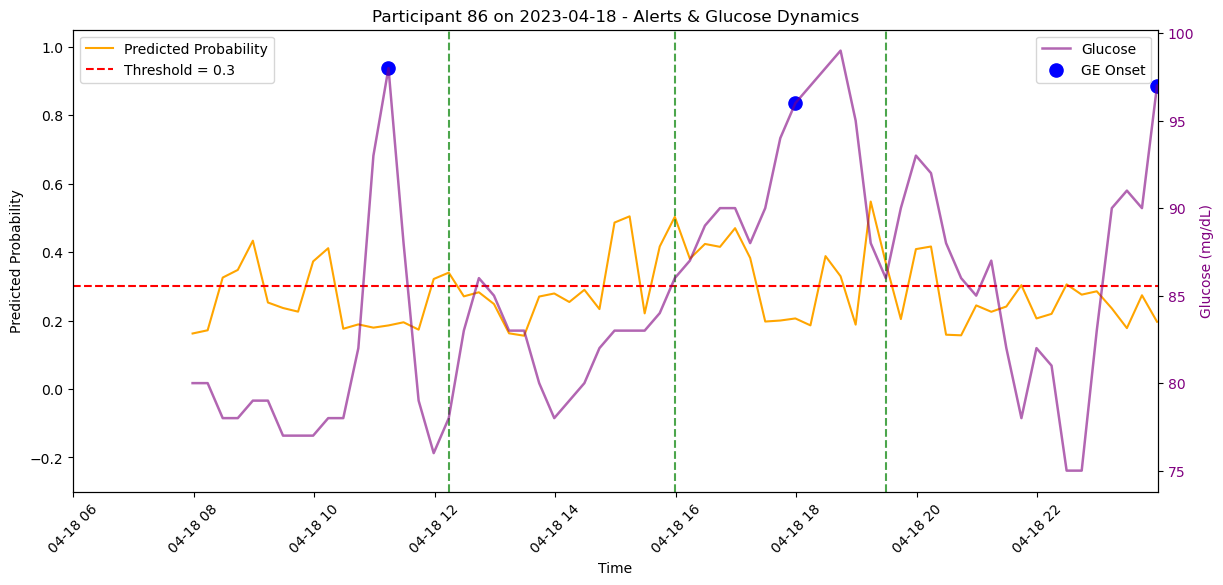

📋 Alert Summary with Delta and Slope:
         Alert_Time  Success    FP     Closest_GE_Time  Time_Diff_Minutes  Glucose_Delta_1_3.5hr  Glucose_Slope_0_3.5hr
2023-04-18 12:14:00    False  True 2023-04-18 17:59:00              345.0                      6                  0.002
2023-04-18 15:59:00     True False 2023-04-18 17:59:00              120.0                     13                  0.029
2023-04-18 19:29:00    False  True 2023-04-18 23:59:00              270.0                      2                 -0.067

✅ Total Alerts: 3 | 🏆 Success: 1 | ❌ FP: 2


In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.linear_model import LinearRegression

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Z_Previous_4", "Previous_4_Glucose"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 알림 탐지 함수 -------------------
def get_alert_times(df, threshold=0.3, cooldown_minutes=210):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    all_ge_df = df[df["Onset_GE"] == 1].copy()
    all_ge_df["Shifted_Timestamp"] = all_ge_df["Timestamp"] + timedelta(minutes=60)
    ge_times = all_ge_df["Shifted_Timestamp"]

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_pre4 = df.loc[i, "Z_Previous_4"]
        pre4 = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_pre4 >= 0.1 and
            pre4 < 130
        ):
            last_data_time = df["Timestamp"].max()
            first_data_time = df["Timestamp"].min()

            success = any((current_time + timedelta(minutes=60) <= ge <= current_time + timedelta(minutes=210)) for ge in ge_times)

            if not success:
                if (last_data_time < current_time + timedelta(minutes=110)) or (first_data_time > current_time - timedelta(minutes=110)):
                    continue

            alert_times.append(current_time)
            last_alert_time = current_time

    return alert_times

# ------------------- 기울기 계산 함수 -------------------
def calculate_slope(timestamps, glucose_values):
    timestamps = timestamps.reset_index(drop=True)
    glucose_values = glucose_values.reset_index(drop=True)

    if len(timestamps) < 2:
        return np.nan

    time_minutes = np.array([(t - timestamps.iloc[0]).total_seconds() / 60 for t in timestamps]).reshape(-1, 1)
    glucose_values = glucose_values.to_numpy().reshape(-1, 1)
    model = LinearRegression().fit(time_minutes, glucose_values)
    return round(model.coef_[0][0], 3)

# ------------------- 시각화 함수 -------------------
def plot_alerts_with_detailed_summary(df, study_id, date, threshold=0.3, cooldown_minutes=210):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)
    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    onset_df = sub_df[sub_df["Onset_GE"] == 1].copy()
    onset_df["Shifted_Timestamp"] = onset_df["Timestamp"] + timedelta(minutes=60)
    shifted_onset_times = onset_df["Shifted_Timestamp"].tolist()

    results = []
    success_count, fp_count = 0, 0

    for alert_time in alert_times:
        future_ge_times = [t for t in shifted_onset_times if t >= alert_time]
        closest_ge, time_diff = (pd.NaT, np.nan)
        if future_ge_times:
            closest_ge = min(future_ge_times)
            time_diff = round((closest_ge - alert_time).total_seconds() / 60, 1)

        success = any(alert_time + timedelta(minutes=60) <= t <= alert_time + timedelta(minutes=210) for t in future_ge_times)

        glucose_0 = sub_df.loc[sub_df["Timestamp"] <= alert_time, "Glucose"].iloc[-1]
        window_1_3hr = sub_df[(sub_df["Timestamp"] >= alert_time + timedelta(minutes=60)) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        delta = (window_1_3hr["Glucose"].max() - glucose_0) if not window_1_3hr.empty else np.nan

        window_0_3hr = sub_df[(sub_df["Timestamp"] >= alert_time) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        slope = calculate_slope(window_0_3hr["Timestamp"], window_0_3hr["Glucose"]) if not window_0_3hr.empty else np.nan

        results.append({
            "Alert_Time": alert_time,
            "Success": success,
            "FP": not success,
            "Closest_GE_Time": closest_ge,
            "Time_Diff_Minutes": time_diff,
            "Glucose_Delta_1_3.5hr": round(delta, 1) if pd.notna(delta) else np.nan,
            "Glucose_Slope_0_3.5hr": slope
        })

        success_count += success
        fp_count += not success

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)
    ax1.set_ylabel("Predicted Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    plt.xticks(rotation=45)

    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")
        if not onset_df.empty:
            shifted_times = onset_df["Shifted_Timestamp"]
            glucose_interp = np.interp(
                shifted_times.astype(np.int64),
                sub_df["Timestamp"].astype(np.int64),
                sub_df["Glucose"]
            )
            ax2.scatter(shifted_times, glucose_interp, color="blue", s=90, label="GE Onset")
        ax2.legend(loc="upper right")

    plt.title(f"Participant {study_id} on {date} - Alerts & Glucose Dynamics")
    plt.show()

    result_df = pd.DataFrame(results)
    print("📋 Alert Summary with Delta and Slope:")
    print(result_df.to_string(index=False))
    print(f"\n✅ Total Alerts: {len(alert_times)} | 🏆 Success: {success_count} | ❌ FP: {fp_count}")

# ------------------- 실행 예시 -------------------
participant_id = 86
specific_date = pd.to_datetime("2023-4-18").date()
plot_alerts_with_detailed_summary(holdout_df, participant_id, specific_date, threshold=0.3, cooldown_minutes=210)

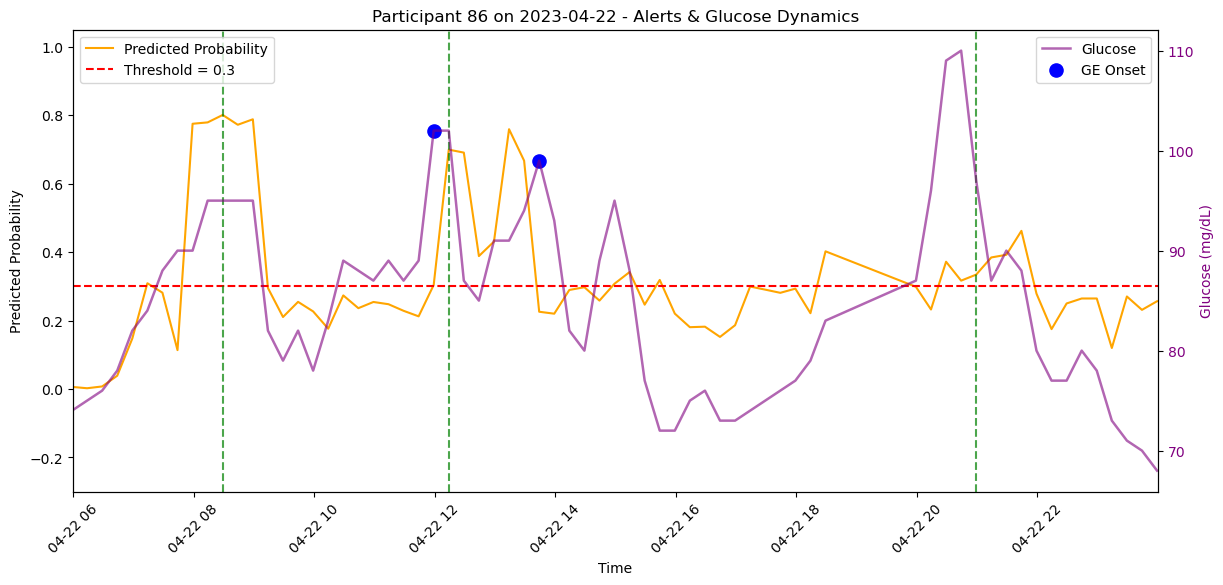

📋 Alert Summary with Delta and Slope:
         Alert_Time  Success    FP     Closest_GE_Time  Time_Diff_Minutes  Glucose_Delta_1_3.5hr  Glucose_Slope_0_3.5hr
2023-04-22 08:29:00     True False 2023-04-22 11:59:00              210.0                      7                  0.011
2023-04-22 12:14:00     True False 2023-04-22 13:44:00               90.0                     -3                 -0.069
2023-04-22 20:59:00    False  True                 NaT                NaN                    -17                 -0.140

✅ Total Alerts: 3 | 🏆 Success: 2 | ❌ FP: 1


In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.linear_model import LinearRegression

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Z_Previous_4", "Previous_4_Glucose"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 알림 탐지 함수 -------------------
def get_alert_times(df, threshold=0.3, cooldown_minutes=210):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    all_ge_df = df[df["Onset_GE"] == 1].copy()
    all_ge_df["Shifted_Timestamp"] = all_ge_df["Timestamp"] + timedelta(minutes=60)
    ge_times = all_ge_df["Shifted_Timestamp"]

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_pre4 = df.loc[i, "Z_Previous_4"]
        pre4 = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_pre4 >= 0.1 and
            pre4 < 130
        ):
            last_data_time = df["Timestamp"].max()
            first_data_time = df["Timestamp"].min()

            success = any((current_time + timedelta(minutes=60) <= ge <= current_time + timedelta(minutes=210)) for ge in ge_times)

            if not success:
                if (last_data_time < current_time + timedelta(minutes=110)) or (first_data_time > current_time - timedelta(minutes=110)):
                    continue

            alert_times.append(current_time)
            last_alert_time = current_time

    return alert_times

# ------------------- 기울기 계산 함수 -------------------
def calculate_slope(timestamps, glucose_values):
    timestamps = timestamps.reset_index(drop=True)
    glucose_values = glucose_values.reset_index(drop=True)

    if len(timestamps) < 2:
        return np.nan

    time_minutes = np.array([(t - timestamps.iloc[0]).total_seconds() / 60 for t in timestamps]).reshape(-1, 1)
    glucose_values = glucose_values.to_numpy().reshape(-1, 1)
    model = LinearRegression().fit(time_minutes, glucose_values)
    return round(model.coef_[0][0], 3)

# ------------------- 시각화 함수 -------------------
def plot_alerts_with_detailed_summary(df, study_id, date, threshold=0.3, cooldown_minutes=210):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)
    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    onset_df = sub_df[sub_df["Onset_GE"] == 1].copy()
    onset_df["Shifted_Timestamp"] = onset_df["Timestamp"] + timedelta(minutes=60)
    shifted_onset_times = onset_df["Shifted_Timestamp"].tolist()

    results = []
    success_count, fp_count = 0, 0

    for alert_time in alert_times:
        future_ge_times = [t for t in shifted_onset_times if t >= alert_time]
        closest_ge, time_diff = (pd.NaT, np.nan)
        if future_ge_times:
            closest_ge = min(future_ge_times)
            time_diff = round((closest_ge - alert_time).total_seconds() / 60, 1)

        success = any(alert_time + timedelta(minutes=60) <= t <= alert_time + timedelta(minutes=210) for t in future_ge_times)

        glucose_0 = sub_df.loc[sub_df["Timestamp"] <= alert_time, "Glucose"].iloc[-1]
        window_1_3hr = sub_df[(sub_df["Timestamp"] >= alert_time + timedelta(minutes=60)) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        delta = (window_1_3hr["Glucose"].max() - glucose_0) if not window_1_3hr.empty else np.nan

        window_0_3hr = sub_df[(sub_df["Timestamp"] >= alert_time) & (sub_df["Timestamp"] <= alert_time + timedelta(minutes=210))]
        slope = calculate_slope(window_0_3hr["Timestamp"], window_0_3hr["Glucose"]) if not window_0_3hr.empty else np.nan

        results.append({
            "Alert_Time": alert_time,
            "Success": success,
            "FP": not success,
            "Closest_GE_Time": closest_ge,
            "Time_Diff_Minutes": time_diff,
            "Glucose_Delta_1_3.5hr": round(delta, 1) if pd.notna(delta) else np.nan,
            "Glucose_Slope_0_3.5hr": slope
        })

        success_count += success
        fp_count += not success

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)
    ax1.set_ylabel("Predicted Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    plt.xticks(rotation=45)

    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")
        if not onset_df.empty:
            shifted_times = onset_df["Shifted_Timestamp"]
            glucose_interp = np.interp(
                shifted_times.astype(np.int64),
                sub_df["Timestamp"].astype(np.int64),
                sub_df["Glucose"]
            )
            ax2.scatter(shifted_times, glucose_interp, color="blue", s=90, label="GE Onset")
        ax2.legend(loc="upper right")

    plt.title(f"Participant {study_id} on {date} - Alerts & Glucose Dynamics")
    plt.show()

    result_df = pd.DataFrame(results)
    print("📋 Alert Summary with Delta and Slope:")
    print(result_df.to_string(index=False))
    print(f"\n✅ Total Alerts: {len(alert_times)} | 🏆 Success: {success_count} | ❌ FP: {fp_count}")

# ------------------- 실행 예시 -------------------
participant_id = 86
specific_date = pd.to_datetime("2023-4-22").date()
plot_alerts_with_detailed_summary(holdout_df, participant_id, specific_date, threshold=0.3, cooldown_minutes=210)